# Harmonic Pattern Recognition With Python

In this video I show python code for pattern recognition of Harmonic Patterns. The code shown finds the Gartley, Bat, Butterfly, Crab, Deep Crab, Cypher, and Shark Harmonic Patterns. These are all XABCD patterns. The code is able to find any other XABCD pattern given the ratios. We backtest the harmonic patterns using hourly bitcoin data.

* Tutorial: [Harmonic Pattern Recognition With Python](https://www.youtube.com/watch?v=ODHlC9YuowY)
* Full Code: https://github.com/neurotrader888/TechnicalAnalysisAutomation

Links

- https://en.wikipedia.org/wiki/Golden_ratio
- https://en.wikipedia.org/wiki/Fibonacci_retracement

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import scipy
from src.directional_change import directional_change, get_extremes
from dataclasses import dataclass
from typing import Union
from math import log
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
@dataclass
class XABCD:
    XA_AB: Union[float, list, None]
    AB_BC: Union[float, list, None]
    BC_CD: Union[float, list, None]
    XA_AD: Union[float, list, None]
    name: str

In [4]:
# Define Patterns
GARTLEY = XABCD(0.618, [0.382, 0.886], [1.13, 1.618], 0.786, "Gartley")
BAT = XABCD([0.382, 0.50], [0.382, 0.886], [1.618, 2.618], 0.886, "Bat")
#ALT_BAT = XABCD(0.382, [0.382, 0.886], [2.0, 3.618], 1.13, "Alt Bat")
BUTTERFLY = XABCD(0.786, [0.382, 0.886], [1.618, 2.24], [1.27, 1.41], "Butterfly")
CRAB = XABCD([0.382, 0.618], [0.382, 0.886], [2.618, 3.618], 1.618, "Crab")
DEEP_CRAB = XABCD(0.886, [0.382, 0.886], [2.0, 3.618], 1.618, "Deep Crab")
CYPHER = XABCD([0.382, 0.618], [1.13, 1.41], [1.27, 2.00], 0.786, "Cypher")
SHARK = XABCD(None, [1.13, 1.618], [1.618, 2.24], [0.886, 1.13], "Shark")
ALL_PATTERNS = [GARTLEY, BAT, BUTTERFLY, CRAB, DEEP_CRAB, CYPHER, SHARK]

In [5]:
@dataclass
class XABCDFound:
    X: int
    A: int
    B: int
    C: int
    D: int # Index of last point in pattern, the entry is on the close of D
    error: float # Error found
    name: str
    bull: bool

In [6]:
def plot_pattern(ohlc: pd.DataFrame, pat: XABCDFound, pad=3):
    idx = ohlc.index
    data = ohlc.iloc[pat.X - pad: pat.D + 1 + pad]

    plt.style.use('dark_background')
    fig = plt.gcf()
    ax = fig.gca()

    if pat.bull:
        s1 = ohlc['low'].to_numpy()
        s2 = ohlc['high'].to_numpy()
    else:
        s2 = ohlc['low'].to_numpy()
        s1 = ohlc['high'].to_numpy()
        

    l0 = [(idx[pat.X], s1[pat.X]), (idx[pat.A], s2[pat.A])]
    l1 = [(idx[pat.A], s2[pat.A]), (idx[pat.B], s1[pat.B])]
    l2 = [(idx[pat.B], s1[pat.B]), (idx[pat.C], s2[pat.C])]
    l3 = [(idx[pat.C], s2[pat.C]), (idx[pat.D], s1[pat.D])]
    
    # Connecting lines
    l4 = [(idx[pat.A], s2[pat.A]), (idx[pat.C], s2[pat.C])]
    l5 = [(idx[pat.B], s1[pat.B]), (idx[pat.D], s1[pat.D])]
    l6 = [(idx[pat.X], s1[pat.X]), (idx[pat.B], s1[pat.B])]
    l7 = [(idx[pat.X], s1[pat.X]), (idx[pat.D], s1[pat.D])]

    mpf.plot(
        data, 
        alines=dict(alines=[l0, l1, l2, l3, l4, l5, l6, l7 ], colors=['w', 'w', 'w', 'w', 'b', 'b', 'b', 'b']),
        type='candle', style='charles', ax=ax
    )
    
    # Text
    xa_ab =  abs(s2[pat.A] - s1[pat.B]) / abs(s1[pat.X] - s2[pat.A])
    ab_bc =  abs(s1[pat.B] - s2[pat.C]) / abs(s2[pat.A] - s1[pat.B])
    bc_cd =  abs(s2[pat.C] - s1[pat.D]) / abs(s1[pat.B] - s2[pat.C])
    xa_ad =  abs(s2[pat.A] - s1[pat.D]) / abs(s1[pat.X] - s2[pat.A])
    ax.text(int((pat.X + pat.B) / 2) - pat.X + pad, (s1[pat.X] + s1[pat.B]) / 2 , str(round(xa_ab, 3)), color='orange', fontsize='x-large')
    ax.text(int((pat.A + pat.C) / 2) - pat.X + pad, (s2[pat.A] + s2[pat.C]) / 2 , str(round(ab_bc, 3)), color='orange', fontsize='x-large')
    ax.text(int((pat.B + pat.D) / 2) - pat.X + pad, (s1[pat.B] + s1[pat.D]) / 2 , str(round(bc_cd, 3)), color='orange', fontsize='x-large')
    ax.text(int((pat.X + pat.D) / 2) - pat.X + pad, (s1[pat.X] + s1[pat.D]) / 2 , str(round(xa_ad, 3)), color='orange', fontsize='x-large')
    
    desc_string = pat.name
    desc_string += "\nError: " + str(round(pat.error , 5))
    if pat.bull:
        plt_price = data['high'].max() - 0.05 * (data['high'].max() - data['low'].min())
    else:
        plt_price = data['low'].min() + 0.05 * (data['high'].max() - data['low'].min())
    ax.text(0, plt_price , desc_string, color='yellow', fontsize='x-large')
    plt.show()

In [7]:
def get_error(actual_ratio: float, pattern_ratio: Union[float, list, None]):
     
    if pattern_ratio is None: # No requirement (Shark)
        return 0.0

    log_actual = log(actual_ratio)

    if isinstance(pattern_ratio, list): # Acceptable range
        log_pat0 = log(pattern_ratio[0])
        log_pat1 = log(pattern_ratio[1])
        assert(log_pat1 > log_pat0)

        if log_pat0 <= log_actual <= log_pat1:
            return 0.0
        #else:
        #    return 1e20

        err = min( abs(log_actual - log_pat0), abs(log_actual - log_pat1) )
        range_mult = 2.0 # Since range is already more lenient, punish harder. 
        err *= range_mult
        return err

    elif isinstance(pattern_ratio, float):
        err = abs(log_actual - log(pattern_ratio))
        return err
    else:
        raise TypeError("Invalid pattern ratio type")

In [8]:
def find_xabcd(ohlc: pd.DataFrame, extremes: pd.DataFrame, err_thresh: float = 0.2):
    
    extremes['seg_height'] = (extremes['ext_p'] - extremes['ext_p'].shift(1)).abs()
    extremes['retrace_ratio'] = extremes['seg_height'] / extremes['seg_height'].shift(1) 
    
    output = {}
    for pat in ALL_PATTERNS:
        pat_data = {}
        pat_data['bull_signal'] = np.zeros(len(ohlc))
        pat_data['bull_patterns'] = []
        pat_data['bear_signal'] = np.zeros(len(ohlc))
        pat_data['bear_patterns'] = []
        output[pat.name] = pat_data
    
    first_conf = extremes.index[0]
    extreme_i = 0
        
    entry_taken = 0
    pattern_used = None
    for i in range(first_conf, len(ohlc)):
        
        if extremes.index[extreme_i + 1] == i:
            entry_taken = 0
            extreme_i += 1
        
        if entry_taken != 0:
            if entry_taken == 1:
                output[pattern_used]['bull_signal'][i] = 1
            else:
                output[pattern_used]['bear_signal'][i] = -1
            continue
        
        if extreme_i + 1 >= len(extremes):
            break
        
        if extreme_i < 3:
            continue

        ext_type = extremes.iloc[extreme_i]['type']
        last_conf_i = extremes.index[extreme_i]

        
        if extremes.iloc[extreme_i]['type'] > 0.0:  
            # Last extreme was a top, meaning we're on a leg down currently.
            # We are checking for bull patterns
            D_price = ohlc.iloc[i]['low']
            # Check that the current low is the lowest since last confirmed top 
            if ohlc.iloc[last_conf_i:i]['low'].min() < D_price:
                continue
        else:
            # Last extreme was a bottom, meaning we're on a leg up currently.
            # We are checking for bear patterns
            D_price = ohlc.iloc[i]['high']
            # Check that the current high is the highest since last confirmed bottom 
            if ohlc.iloc[last_conf_i:i]['high'].max() > D_price:
                continue

         
        # D_Price set, get ratios
        dc_retrace = abs(D_price - extremes.iloc[extreme_i]['ext_p']) / extremes.iloc[extreme_i]['seg_height'] 
        xa_ad_retrace = abs(D_price - extremes.iloc[extreme_i - 2]['ext_p']) / extremes.iloc[extreme_i - 2]['seg_height']
        
        best_err = 1e30
        best_pat = None
        for pat in ALL_PATTERNS:
            err = 0.0
            err += get_error(extremes.iloc[extreme_i]['retrace_ratio'], pat.AB_BC)
            err += get_error(extremes.iloc[extreme_i - 1]['retrace_ratio'], pat.XA_AB)
            err += get_error(dc_retrace, pat.BC_CD)
            err += get_error(xa_ad_retrace, pat.XA_AD)
            if err < best_err:
                best_err = err
                best_pat = pat.name
        
        if best_err <= err_thresh:
            pattern_data = XABCDFound(
                    int(extremes.iloc[extreme_i - 3]['ext_i']), 
                    int(extremes.iloc[extreme_i - 2]['ext_i']), 
                    int(extremes.iloc[extreme_i - 1]['ext_i']), 
                    int(extremes.iloc[extreme_i]['ext_i']), 
                    i, 
                    best_err, best_pat, True
            )

            pattern_used = best_pat
            if ext_type > 0.0:
                entry_taken = 1
                pattern_data.name = "Bull" + pattern_data.name
                pattern_data.bull = True
                output[pattern_used]['bull_signal'][i] = 1
                output[pattern_used]['bull_patterns'].append(pattern_data)
            else:
                entry_taken = -1
                pattern_data.name = "Bear" + pattern_data.name
                pattern_data.bull = False
                output[pattern_used]['bear_signal'][i] = -1
                output[pattern_used]['bear_patterns'].append(pattern_data)

    return output

In [9]:
# Load data

data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
#data = data[data.index < '2019-01-01']

In [10]:
# This takes a while to run fyi

data['r'] = np.log(data['close']).diff().shift(-1)
all_combined = np.zeros(len(data))
sigmas = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
for sigma in tqdm(sigmas):
    
    extremes = get_extremes(data, sigma)
    output =  find_xabcd(data, extremes, 0.5)
    sig = np.zeros(len(data))
    for pat in ALL_PATTERNS:
        sig += output[pat.name]['bear_signal'] + output[pat.name]['bull_signal']
    all_combined += sig
    # print("done", sigma)

all_combined /= len(sigmas)
data['combined_signal'] = all_combined
data['combined_returns'] = data['r'] * data['combined_signal']
win_returns = data[data['combined_returns'] > 0]['combined_returns'].sum() 
lose_returns = data[data['combined_returns'] < 0]['combined_returns'].abs().sum() 
combined_pf = win_returns / lose_returns
print("Combined PF", combined_pf)

100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:39<00:00,  5.58s/it]

Combined PF 1.050207793798259


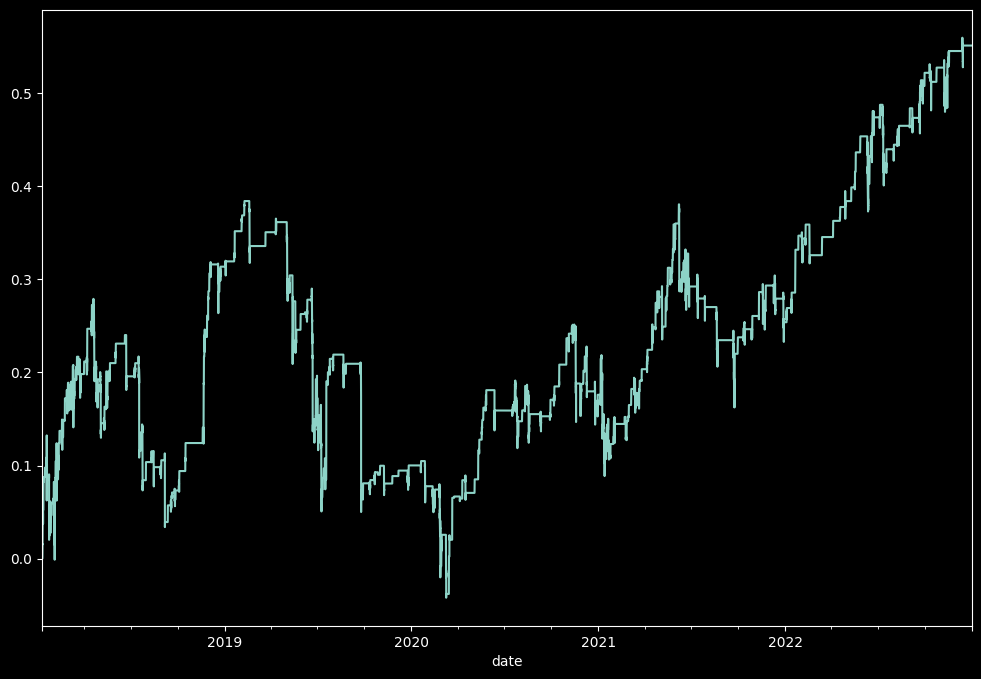

In [11]:
# Test single set of parameters
extremes = get_extremes(data, 0.02)
output =  find_xabcd(data, extremes, 0.2)

sig = np.zeros(len(data))
for pat in ALL_PATTERNS:
    sig += output[pat.name]['bear_signal'] + output[pat.name]['bull_signal']

data['r'] = np.log(data['close']).diff().shift(-1)
data['signal_return'] = data['r'] * sig # Returns of all patterns combined
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
data['signal_return'].cumsum().plot()
plt.show()

0.01 Profit Factor:  1.0789973579725995
0.015 Profit Factor:  1.1002207396089743
0.02 Profit Factor:  1.06467209095151
0.025 Profit Factor:  0.9748002282546828
0.03 Profit Factor:  1.0145106718139636
0.035 Profit Factor:  0.9758285114000862
0.04 Profit Factor:  1.0038457825506235


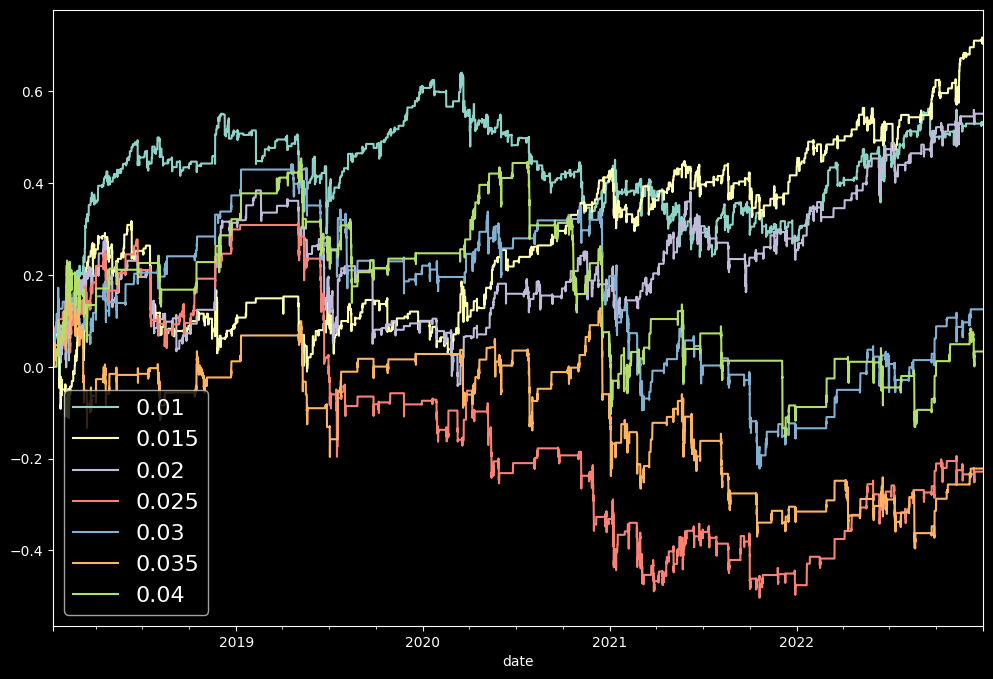

In [12]:
# Test several sigma vvalues
data['r'] = np.log(data['close']).diff().shift(-1)
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
for sigma in [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]: 
    extremes = get_extremes(data, sigma)
    output =  find_xabcd(data, extremes, 0.2)
    sig = np.zeros(len(data))
    for pat in ALL_PATTERNS:
        sig += output[pat.name]['bear_signal'] + output[pat.name]['bull_signal']

    data['signal_return'] = data['r'] * sig # Returns of all patterns combined
    data['signal_return'].cumsum().plot(label=str(sigma))
    pf = data[data['signal_return'] > 0]['signal_return'].sum() / data[data['signal_return'] < 0]['signal_return'].abs().sum()
    print(sigma, "Profit Factor: ", pf)
plt.legend(prop={'size': 16})
plt.show()

100%|███████████████████████████████████████████████████████████████████| 13/13 [08:22<00:00, 38.64s/it]


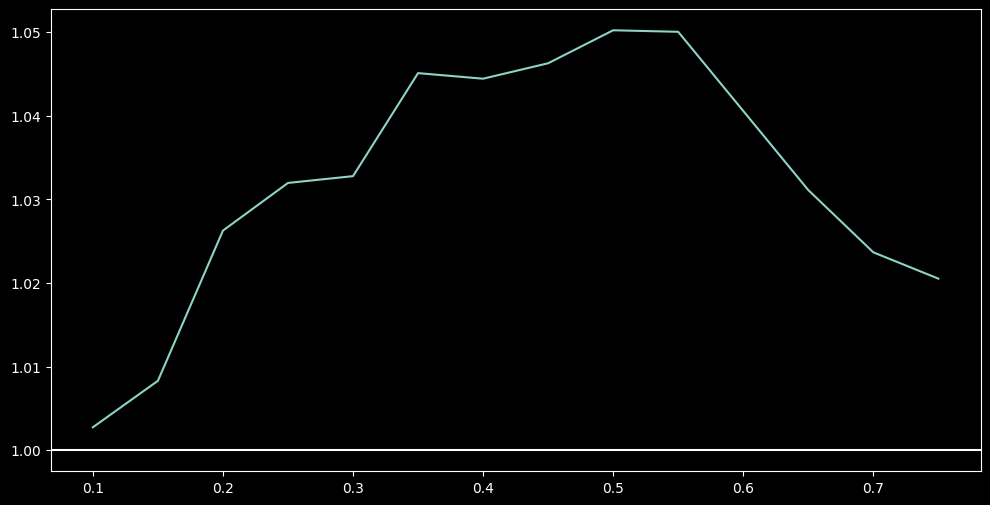

In [13]:
# Render error graph
all_pfs = []
all_thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.65, 0.7, 0.75]
#all_thresholds = [0.1, 0.15]
for threshold in tqdm(all_thresholds):
    all_combined = np.zeros(len(data))
    sigmas = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
    for sigma in sigmas: 
        extremes = get_extremes(data, sigma)
        output =  find_xabcd(data, extremes, threshold)
        sig = np.zeros(len(data))
        for pat in ALL_PATTERNS:
            sig += output[pat.name]['bear_signal'] + output[pat.name]['bull_signal']

        all_combined += sig 
    all_combined /= len(sigmas)
    data['combined_signal'] = all_combined
    data['combined_returns'] = data['r'] * data['combined_signal']
    win_returns = data[data['combined_returns'] > 0]['combined_returns'].sum() 
    lose_returns = data[data['combined_returns'] < 0]['combined_returns'].abs().sum() 
    combined_pf = win_returns / lose_returns
    all_pfs.append(combined_pf)

plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
err_thresh_pfs = pd.Series(all_pfs, index=all_thresholds)
err_thresh_pfs.plot()
plt.axhline(1.0, color='white')
plt.show()

In [14]:
# Find best err pattern
best_pat = None
best_err = 1000
for pat in output['Gartley']['bull_patterns']:
    if pat.error < best_err:
        best_err = pat.error
        best_pat = pat

In [15]:
# Bar Charts by pattern PF and count
sigmas = []
patterns = []
pfs = []
counts = []
#for sigma in [0.01, 0.02, 0.03, 0.04]: 
for sigma in tqdm([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]):
    extremes = get_extremes(data, sigma)
    output =  find_xabcd(data, extremes, 0.2)
    for pat in ALL_PATTERNS:
        sig = output[pat.name]['bear_signal'] + output[pat.name]['bull_signal']
        count = len(output[pat.name]['bear_patterns']) + len(output[pat.name]['bull_patterns'])
        rets = (data['r'] * sig)
        pf = rets[rets > 0].sum() / rets[rets < 0].abs().sum()
        if np.isnan(pf): # Set nan value to a neutral 1.0 for profit factor
            pf = 1.0

        if pf > 4.0: # put a ceil at 4, as that high of PF is from low sample size. Makes graph look better 
            pf = 4.0

        sigmas.append(sigma)
        patterns.append(pat.name)
        pfs.append(pf)
        counts.append(count)

100%|█████████████████████████████████████████████████████████████████████| 7/7 [00:39<00:00,  5.70s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


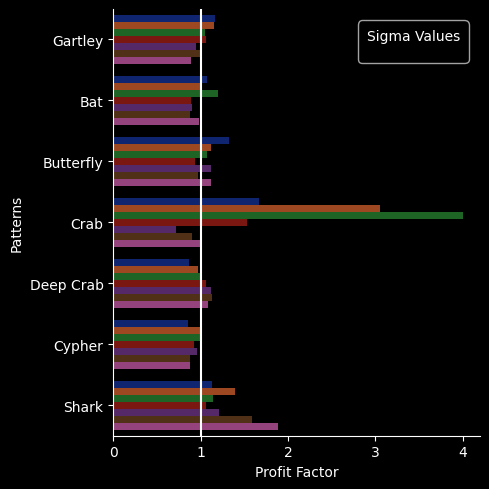

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


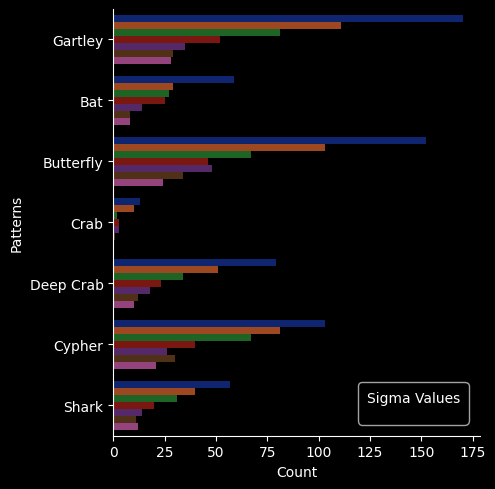

In [16]:
df = pd.DataFrame()
df['sigmas'] = sigmas
df['Patterns'] = patterns
df['Profit Factor'] = pfs
df['Count'] = counts
    
plt.style.use('dark_background')
sns.catplot(
    data=df, y="Patterns", x='Profit Factor', hue="sigmas", kind='bar',
    palette="dark", edgecolor=".6", legend=False
)
plt.axvline(1.0, color='white')
plt.legend(prop={'size': 16}, title='Sigma Values')
plt.show()

sns.catplot(
    data=df, y="Patterns", x='Count', hue="sigmas", kind='bar',
    palette="dark", edgecolor=".6", legend=False
)
plt.legend(prop={'size': 16}, title='Sigma Values')
plt.show()